In [1]:
# last updated date: 2/25/2025
# german credit data visualization

In [2]:

import numpy as np
import pandas as pd
import pickle
import random
import timeit
import os

from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import Hypervolume
from matplotlib import pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from german_credit_prob_using_error import GermanCreditProblem

np.random.seed(42)
random.seed(42)

# Set pandas options to display all rows and columns
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)  # Disable line wrapping
pd.set_option("display.max_colwidth", None)  # Disable truncation for column width


def process_data(file_name, class_label):
    # read the data
    data = pd.read_csv(file_name)

    columns_to_keep = [
        "Duration in month",
        "Credit amount",
        "Installment rate in percentage of disposable income",
        "Status of existing checking account",
        "Credit history",
        "Purpose",
        "Savings account/bonds",
        "Present employment since",
        "Other debtors / guarantors",
        "Property",
        "Other installment plans",
        "Job",
        "Risk",
    ]

    # Select only the specified columns
    df_selected = data[columns_to_keep]
    # rename some columns for better readability
    df_selected = df_selected.rename(
        columns={
            "Duration in month": "Duration",
            "Credit amount": "CreditAmount",
            "Installment rate in percentage of disposable income": "InstallmentRate",
            "Status of existing checking account": "CheckingAccount",
            "Credit history": "CreditHistory",
            "Savings account/bonds": "Savings",
            "Present employment since": "Employment",
            "Other debtors / guarantors": "OtherDebtors",
            "Other installment plans": "OtherInstallPlans",
        }
    )

    # select the target class and keep that column separately
    target_class = df_selected[class_label]

    # drop the target class from the data
    data_wo_label = df_selected.drop(columns=[class_label])
    
    min_values = data_wo_label[["Duration", "CreditAmount", "InstallmentRate"]].min()
    max_values = data_wo_label[["Duration", "CreditAmount", "InstallmentRate"]].max()

    return data_wo_label, target_class, min_values, max_values


def train_and_save_model(data_wo_label, target_class, model_filename):
    categorical_columns = [
        "CheckingAccount",
        "CreditHistory",
        "Purpose",
        "Savings",
        "Employment",
        "OtherDebtors",
        "Property",
        "OtherInstallPlans",
        "Job",
    ]

    # apply one-hot encoding to the categorical columns
    data_for_model = pd.get_dummies(data_wo_label, columns=categorical_columns)

    # convert boolean values to int
    data_for_model = data_for_model.astype(int)

    X = data_for_model
    y = target_class
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # standardize the numerical features before training the model
    numerical_features = ["Duration", "CreditAmount", "InstallmentRate"]
    categorical_features = data_for_model.columns.difference(
        numerical_features
    ).tolist()  # get all one-hot encoded column names dynamically

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_features),
            ("cat", "passthrough", categorical_features),
        ]
    )  # leave categorical features untransformed

    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", MLPClassifier(random_state=42)),
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # save the trained model
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Model saved as {model_filename}")


def load_model(model_filename, data_wo_label, target_class):
    # check if the model file exists
    if os.path.exists(model_filename):
        # load the existing model
        with open(model_filename, "rb") as file:
            loaded_model = pickle.load(file)
        print(f"Model loaded from existing file, {model_filename}")
    else:
        print(f"Model file {model_filename} is missing.")
        # if the model file is missing, train and save a new model
        train_and_save_model(data_wo_label, target_class, model_filename)
        # reload the newly saved model
        with open(model_filename, "rb") as file:
            loaded_model = pickle.load(file)
        print(f"Model reloaded from {model_filename}")

    return loaded_model



In [3]:
file_name = "german.csv"
extracted_data_name = file_name.split(".")[0]
class_label = "Risk"
data_wo_label, target_class, min_values, max_values = process_data(
    file_name, class_label
)
col_list = data_wo_label.columns.to_list()
model_filename = "german_credit_model.pkl"
loaded_model = load_model(model_filename, data_wo_label, target_class)

combined_data = pd.concat([data_wo_label, target_class], axis=1)

# select 10 bad samples from the data (1 = Good, 2 = Bad)
bad_samples = combined_data[combined_data["Risk"] == 2].sample(
    n=10, random_state=42
)
bad_samples = bad_samples.drop(columns=["Risk"])  # drop the target variable
#print("bad sample list", bad_samples)

#for idx in bad_samples.index:
    #print("idx", idx)
idx = 405
bad_sample = bad_samples.loc[idx]


Model loaded from existing file, german_credit_model.pkl


In [4]:
def save_hist_FX(hist_F, hist_X, extracted_data_name, pop_size, idx, data_wo_label):

    # Process hist_F and hist_X to save in a .csv file
    data = []
    f1_values = []
    f2_values = []
    for f_arr, x_list in zip(hist_F, hist_X):
        for f, x in zip(f_arr, x_list):
            # Flatten and combine F and X values
            row = {"F1": f[0], "F2": f[1], "X": x}
            data.append(row)

            # Save the f1 and f2 values for plotting
            f1_values.append(f[0])
            f2_values.append(f[1])

    # Convert to df
    df = pd.DataFrame(data)
    print("shape of history: ", df.shape)
    print(df.head())
    

In [5]:
problem = GermanCreditProblem(
    loaded_model,
    original_sample=bad_sample,
    sample_idx=idx,
    desired_class=1,
    min_values=min_values,
    max_values=max_values,
)

# set the population size
pop_size = 100

# initialize the algorithm
algorithm = MixedVariableGA(
    pop_size=pop_size, survival=RankAndCrowdingSurvival()
)


In [6]:
# run the optimization
res = minimize(
    problem, algorithm, ("n_gen", 100), seed=1, save_history=True, verbose=False
)

for f1, f2 in zip(problem.all_f1, problem.all_f2):
    print(f"f1: {f1}, f2: {f2}\n")

f1: 0.09246184279483392, f2: 0.8116002899766024

f1: 0.09843645884112404, f2: 0.5141232109534642

f1: 0.7643444062204959, f2: 0.8251641589022997

f1: 0.48434332432409305, f2: 0.9074876967966212

f1: 0.00028993224946282053, f2: 0.5360078517550366

f1: 0.05554688647532966, f2: 0.3339119160676202

f1: 0.0545400708851652, f2: 0.8373538386190732

f1: 0.7586482078452187, f2: 0.7420909559220359

f1: 0.8868345446729541, f2: 0.10732022590896281

f1: 0.05799813563837522, f2: 0.2992880853390728

f1: 0.12496093990620671, f2: 0.011996167343420825

f1: 0.004562747653634342, f2: 0.9471174169016517

f1: 0.3603331908121111, f2: 0.0022163896650763777

f1: 0.2720594191718784, f2: 0.07756755395585693

f1: 0.9830680282922994, f2: 0.9204890865728323

f1: 0.9980948866259807, f2: 0.2887811772475664

f1: 0.0330057945896071, f2: 0.3785472666219931

f1: 0.023997953031538895, f2: 0.4223090372263936

f1: 0.39092265487308364, f2: 0.09138124089469077

f1: 0.0012996177988758378, f2: 0.07700647911763134

f1: 0.0037796

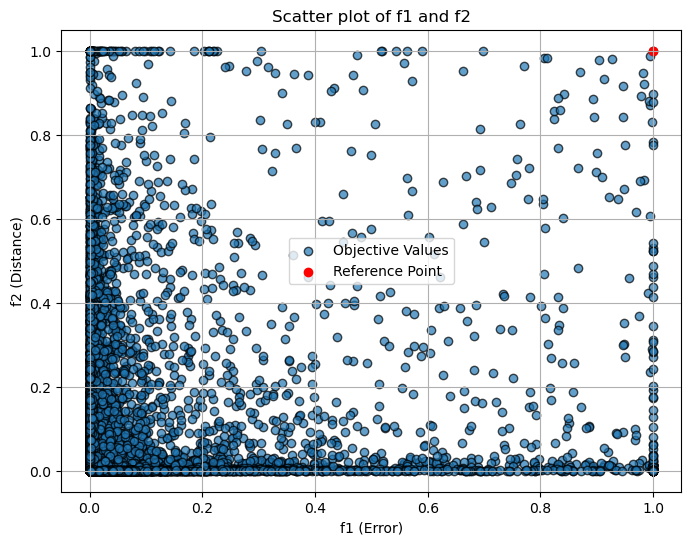

In [7]:

# create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    problem.all_f1,
    problem.all_f2,
    alpha=0.7,
    edgecolors="k",
    label="Objective Values",
)
plt.scatter(
    problem.max_error, problem.max_distance, color="red", label="Reference Point"
)
plt.title("Scatter plot of f1 and f2")
plt.xlabel("f1 (Error)")
plt.ylabel("f2 (Distance)")
plt.legend(loc="center", bbox_to_anchor=(0.5, 0.5))
plt.grid(True)
plt.show()


          Error  Distance
0  5.513199e-05  0.000000
1  2.442838e-05  0.000063
2  0.000000e+00  0.000239
3  3.932174e-06  0.000209
4  4.231465e-05  0.000055
5  1.162248e-07  0.000218
6  3.966353e-06  0.000196
7  2.183492e-05  0.000118
8  1.123330e-05  0.000173


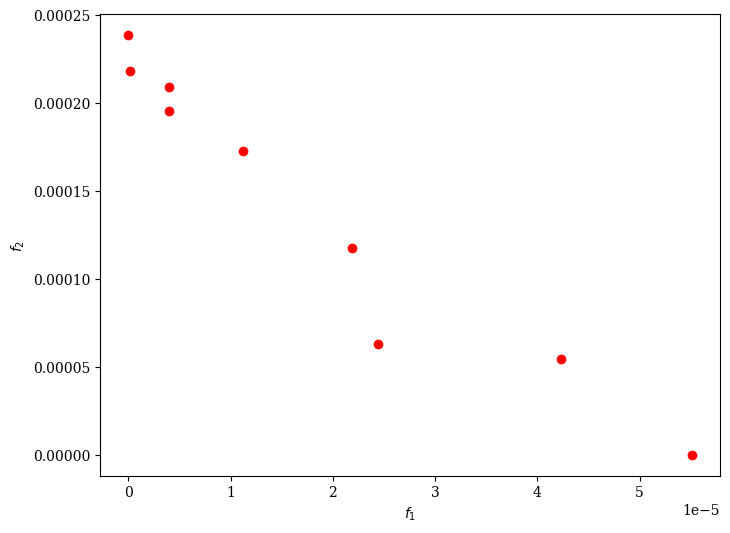

In [8]:
X, F = res.opt.get("X", "F")
# create a scatter plot of the Pareto front
plot = Scatter()
plot.add(res.F, color="red")
plot.show()

# save the dots
pareto_front = res.F
pareto_front_df = pd.DataFrame(pareto_front, columns=["Error", "Distance"])
print(pareto_front_df)


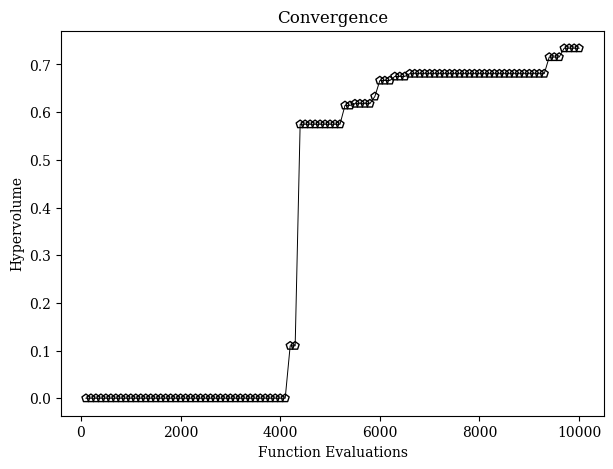

In [9]:

hist = res.history

n_evals = []  # number of evaluations
hist_F = []  # objective space values in each generation
hist_X = []  # design variable values in each generation

for algo in hist:
    n_evals.append(algo.evaluator.n_eval)
    opt = algo.opt

    feas = np.where(opt.get("feasible"))[0]

    hist_F.append(opt.get("F")[feas])
    hist_X.append(opt.get("X")[feas])

# hypervolume (HV)
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

buffer = 0.1
ref_point = np.array([problem.max_error + buffer, problem.max_distance + buffer])
metric = Hypervolume(
    ref_point=ref_point,
    norm_ref_point=False,
    zero_to_one=True,
    ideal=approx_ideal,
    nadir=approx_nadir,
)

hv = [metric.do(_F) for _F in hist_F]


plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv, color="black", lw=0.7)
plt.scatter(n_evals, hv, facecolor="none", edgecolor="black", marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

In [10]:
# save the hypervolume values
hv_df = pd.DataFrame(hv)
print("Hypervolume values: ")
print(hv_df)


Hypervolume values: 
           0
0   0.000000
1   0.000000
2   0.000000
3   0.000000
4   0.000000
5   0.000000
6   0.000000
7   0.000000
8   0.000000
9   0.000000
10  0.000000
11  0.000000
12  0.000000
13  0.000000
14  0.000000
15  0.000000
16  0.000000
17  0.000000
18  0.000000
19  0.000000
20  0.000000
21  0.000000
22  0.000000
23  0.000000
24  0.000000
25  0.000000
26  0.000000
27  0.000000
28  0.000000
29  0.000000
30  0.000000
31  0.000000
32  0.000000
33  0.000000
34  0.000000
35  0.000000
36  0.000000
37  0.000000
38  0.000000
39  0.000000
40  0.000000
41  0.110000
42  0.110000
43  0.574606
44  0.574606
45  0.574606
46  0.574606
47  0.574606
48  0.574606
49  0.574606
50  0.574606
51  0.574606
52  0.614123
53  0.614123
54  0.617826
55  0.617826
56  0.617826
57  0.617826
58  0.632910
59  0.666325
60  0.666325
61  0.666325
62  0.674887
63  0.674887
64  0.674887
65  0.680745
66  0.680745
67  0.680745
68  0.680745
69  0.680745
70  0.680745
71  0.680745
72  0.680745
73  0.680745
74  

In [16]:

def log_results(genomes, bad_sample, data_wo_label):
    col_list = data_wo_label.columns.to_list()
    # display the original bad sample
    val_dict = dict(zip(col_list, bad_sample))
    print("Bad sample: ")
    print(f"{val_dict},\n")
    
    # log the generated counterfactuals
    print("Generated counterfactuals: ")
    for i, genome in enumerate(genomes):
        genome_dict = dict(zip(col_list, genome.values()))

        print(f"{i+1}: {genome_dict},\n")


In [14]:
print(f"bad sample index {idx}: \n", bad_sample)


bad sample index 405: 
 Duration               24
CreditAmount         2039
InstallmentRate         1
CheckingAccount       A12
CreditHistory         A32
Purpose               A43
Savings               A61
Employment            A72
OtherDebtors         A101
Property             A122
OtherInstallPlans    A143
Job                  A173
Name: 405, dtype: object


# Column Description
1. Duration:  (numerical)
Duration in month

2. CreditAmount:  (numerical)
Credit amount

3. InstallmentRate:  (numerical)
Installment rate in percentage of disposable income

4. CheckingAccount: (qualitative)      
Status of existing checking account
      A11 :      ... <    0 DM
	  A12 : 0 <= ... <  200 DM
	  A13 :      ... >= 200 DM / salary assignments for at least 1 year
      A14 : no checking account

5. CreditHistory:  (qualitative)
Credit history
   A30 : no credits taken/ all credits paid back duly
   A31 : all credits at this bank paid back duly
   A32 : existing credits paid back duly till now
   A33 : delay in paying off in the past
   A34 : critical account/ other credits existing (not at this bank)

6. Purpose:  (qualitative)
Purpose
	      A40 : car (new)
	      A41 : car (used)
	      A42 : furniture/equipment
	      A43 : radio/television
	      A44 : domestic appliances
	      A45 : repairs
	      A46 : education
	      A47 : (vacation - does not exist?)
	      A48 : retraining
	      A49 : business
	      A410 : others

7. Savings:  (qualitative)
Savings account/bonds
	      A61 :          ... <  100 DM
	      A62 :   100 <= ... <  500 DM
	      A63 :   500 <= ... < 1000 DM
	      A64 :          .. >= 1000 DM
              A65 :   unknown/ no savings account

8. Employment:  (qualitative)
Present employment since
	      A71 : unemployed
	      A72 :       ... < 1 year
	      A73 : 1  <= ... < 4 years  
	      A74 : 4  <= ... < 7 years
	      A75 :       .. >= 7 years


9. OtherDebtors: (qualitative)
Other debtors / guarantors
	      A101 : none
	      A102 : co-applicant
	      A103 : guarantor


10. Property: (qualitative)
Property
	      A121 : real estate
	      A122 : if not A121 : building society savings agreement/ life insurance
              A123 : if not A121/A122 : car or other, not in attribute 6
	      A124 : unknown / no property


11. OtherInstallPlans: (qualitative)
Other installment plans 
	      A141 : bank
	      A142 : stores
	      A143 : none


12. Job: (qualitative)
Job
	      A171 : unemployed/ unskilled  - non-resident
	      A172 : unskilled - resident
	      A173 : skilled employee / official
	      A174 : management/ self-employed/
		     highly qualified employee/ officer



In [17]:
log_results(problem.all_genomes, bad_sample, data_wo_label)


Bad sample: 
{'Duration': 24, 'CreditAmount': 2039, 'InstallmentRate': 1, 'CheckingAccount': 'A12', 'CreditHistory': 'A32', 'Purpose': 'A43', 'Savings': 'A61', 'Employment': 'A72', 'OtherDebtors': 'A101', 'Property': 'A122', 'OtherInstallPlans': 'A143', 'Job': 'A173'},

Generated counterfactuals: 
1: {'Duration': 24, 'CreditAmount': 2039, 'InstallmentRate': 1, 'CheckingAccount': 'A13', 'CreditHistory': 'A33', 'Purpose': 'A41', 'Savings': 'A64', 'Employment': 'A71', 'OtherDebtors': 'A101', 'Property': 'A122', 'OtherInstallPlans': 'A141', 'Job': 'A171'},

2: {'Duration': 24, 'CreditAmount': 2040, 'InstallmentRate': 1, 'CheckingAccount': 'A11', 'CreditHistory': 'A33', 'Purpose': 'A46', 'Savings': 'A65', 'Employment': 'A75', 'OtherDebtors': 'A101', 'Property': 'A121', 'OtherInstallPlans': 'A142', 'Job': 'A173'},

3: {'Duration': 24, 'CreditAmount': 2032, 'InstallmentRate': 2, 'CheckingAccount': 'A12', 'CreditHistory': 'A33', 'Purpose': 'A48', 'Savings': 'A61', 'Employment': 'A72', 'OtherDe

In [15]:
save_hist_FX(hist_F, hist_X, extracted_data_name, pop_size, idx, data_wo_label)


shape of history:  (541, 3)
         F1        F2  \
0  0.000290  0.536008   
1  0.001300  0.077006   
2  0.003704  0.021878   
3  0.160431  0.000000   
4  0.121398  0.008645   

                                                                                                                                                                                                                                                                   X  
0  {'Duration': 68, 'CreditAmount': 10666, 'InstallmentRate': 1, 'CheckingAccount': 'A13', 'CreditHistory': 'A32', 'Purpose': 'A410', 'Savings': 'A65', 'Employment': 'A72', 'OtherDebtors': 'A101', 'Property': 'A124', 'OtherInstallPlans': 'A143', 'Job': 'A174'}  
1     {'Duration': 13, 'CreditAmount': 755, 'InstallmentRate': 4, 'CheckingAccount': 'A11', 'CreditHistory': 'A32', 'Purpose': 'A42', 'Savings': 'A63', 'Employment': 'A73', 'OtherDebtors': 'A103', 'Property': 'A121', 'OtherInstallPlans': 'A142', 'Job': 'A171'}  
2    {'Duration': 65, 'CreditAmo